# I. Imports and Configurations

In [450]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, make_scorer
from IPython.display import display, Image
from itertools import combinations
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

pd.set_option("display.precision", 1)
np.set_printoptions(precision=1, suppress=True)
ecm = make_scorer(mean_absolute_error)
ecm_name = 'mae'
cv_value = None

raw_dataset = pd.read_csv('dataset.csv', sep=',', skipinitialspace=True)
dataset = raw_dataset.copy()
predict_set = dataset.tail(20)
dataset = dataset.drop(predict_set.index)

predictors = ['SampleNo', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6']

# II. Functions and Classes

In [451]:
# Utility Classes
class ModelResult:
    def __init__(self, info_dict: dict):
        self.model = info_dict['model']
        self.arg = info_dict['arg']
        self.predictors = info_dict['predictors']
        self.predicted = info_dict['predicted']
        self.error = info_dict['error']
        if 'estimator' in info_dict.keys():
            self.estimator = info_dict['estimator']


class ModelResultsTable:
    def __init__(self):
        self.all_model_results = {}
        self.model_results_with_best_params = []

    def add_model(self, model_results: list):
        sorted_models = list(sorted(model_results, key=lambda item: item.error))
        best_performing_var = sorted_models[0]
        self.all_model_results[best_performing_var.model] = sorted_models
        self.model_results_with_best_params.append(best_performing_var)
        self.model_results_with_best_params = list(sorted(self.model_results_with_best_params,
                                                          key=lambda item: item.error))

    def error_table(self, transpose=False, model='best', top=1000, return_table=False, display_table=True):
        if model == 'all':
            error_table = []
            for model_result in self.all_model_results.values():
                error_table.extend([[result.error, result.model, result.predictors, result.arg]
                                    for result in model_result[:top]])
            error_table = pd.DataFrame(error_table, columns=[ecm_name, 'model', 'predictors', 'arg'])
            error_table.sort_values(by=[ecm_name], inplace=True, ignore_index=True)
        elif model == 'best':
            model_indexes = [model_result.model for model_result in self.model_results_with_best_params[:top]]
            error_table = pd.DataFrame([[result.arg, result.predictors, result.error]
                                        for result in self.model_results_with_best_params[:top]],
                                       columns=['args', 'predictors', ecm_name], index=model_indexes)
        else:
            arg_indexes = [model_result.arg for model_result in self.all_model_results[model][:top]]
            error_table = pd.DataFrame([[result.predictors, result.error]
                                        for result in self.all_model_results[model][:top]],
                                       columns=['predictors', ecm_name], index=arg_indexes)
        if transpose:
            error_table = error_table.transpose()
        if display_table:
            display(error_table)
        if return_table:
            return error_table


class ModelTree:
    def __init__(self, source_set, inputs=predictors):
        self.inputs = inputs
        self.input_combinations = get_combinations(inputs=inputs, min_element=1)
        self.models_list = [{'model': single_linear_regression,
                             'predictors': [[p] for p in predictors], # 'predictors': predictors,
                             'arg': [0]},
                            {'model': multiple_linear_regression,
                             'predictors': get_combinations(inputs=inputs),
                             'arg': [0]},
                            {'model': polynomial_regression,
                             'predictors': self.input_combinations,
                             'arg': range(2, 5)},
                            {'model': k_nearest_regression,
                             'predictors': self.input_combinations, 'arg': range(1, 6)},
                            {'model': decision_tree_regression,
                             'predictors': self.input_combinations, 'arg': range(1, 6)}]
        self.source_set = source_set
        self.node_conditions = None
        self.leaf_models = None
        self.conditional_sets = None
        self.conditional_fits_table = []

    def fit_conditions(self, node_conditions):
        self.node_conditions = node_conditions
        self.leaf_models = [None] * len(node_conditions)
        self.conditional_sets = self.get_decision_sets()
        for cond_set in self.conditional_sets:
            fit_result_table = ModelResultsTable()
            for model in self.models_list:
                fit_result_models = [model['model'](x=cond_set, y=cond_set['Y'], inputs=p, arg=a)
                                     for p in model['predictors']
                                     for a in model['arg']]
                fit_result_table.add_model(fit_result_models)
            self.conditional_fits_table.append(fit_result_table)

    def select_leaf_models(self, model_results: list):
        for m_i in range(len(model_results)):
            m_r = model_results[m_i]
            if m_r.arg != '':
                arg = int(m_r.arg.split('=')[1])
            else:
                arg = None
            model_result = globals()[m_r.model](x=self.conditional_sets[m_i][self.inputs],
                                                y=self.conditional_sets[m_i]['Y'],
                                                inputs=m_r.predictors, arg=arg, keep_estimator=True)
            self.leaf_models[m_i] = model_result

    def get_decision_sets(self):
        return_set = []
        sample_set = self.source_set.copy()
        for condition in self.node_conditions:
            if condition == self.node_conditions[-1]:
                return_set.append(sample_set)
                break
            predictor, operator, threshold = condition[:2], condition[2], int(condition[3:])
            lt, gt = split_by_threshold(sample_set, predictor, threshold)
            if operator == '<':
                return_set.append(lt)
                sample_set = gt
            else:
                return_set.append(gt)
                sample_set = lt
        return return_set

    def predict(self, x):
        predictions = pd.DataFrame()
        p_sets = get_decision_sets(x, self.node_conditions)

        for c_model, p_set in zip(self.leaf_models, p_sets):
            estimator = c_model.estimator
            inputs = c_model.predictors
            test_set = p_set[inputs]

            if c_model.model == 'polynomial_regression':
                degree = int(c_model.arg.split('=')[-1])
                test_set = PolynomialFeatures(degree=degree, include_bias=False).fit_transform(test_set)

            y_predicted = estimator.predict(test_set)
            predictions = pd.concat([predictions,
                                     pd.DataFrame({'Predictions': y_predicted}, index=p_set.index)])

        return predictions.sort_index()
    
    def plot_models(self, plot_titles, angle_3d=-96, cmap='r'):
        fig = plt.figure(figsize=(18, 5))
        cv_error = 0
        plot_i = 1
        decision_df = pd.DataFrame(columns=['Model', 'Predictors', 'Args', 'Error'])
    
        for cond_model, cond_set, plot_title in zip(self.leaf_models, self.conditional_sets, plot_titles):
            decision_df.loc[plot_title] = [cond_model.model, cond_model.predictors,
                                           cond_model.arg, cond_model.error]
            if len(cond_model.predictors) == 1:
                ax = fig.add_subplot(1, 3, plot_i)
                sns.scatterplot(ax=ax, x=cond_set[cond_model.predictors[0]], y=cond_set['Y'],
                                color='b', label='Actual Data')
                sns.scatterplot(ax=ax, x=cond_set[cond_model.predictors[0]], y=cond_model.predicted,
                                color='r', label='Predicted')
                ax.set_title(plot_title)
            elif len(cond_model.predictors) == 2:
                ax = fig.add_subplot(1, 3, plot_i, projection='3d')
                ax.view_init(elev=2., azim=angle_3d)
                ax.set_box_aspect(aspect=None, zoom=1.35)
    
                x_axis = cond_model.predictors[0]
                y_axis = cond_model.predictors[1]
                z_axis = 'Y'
    
                ax.scatter(cond_set[x_axis],
                           cond_set[y_axis],
                           cond_set[z_axis],
                           c=cond_set[z_axis])
                ax.plot_trisurf(cond_set[x_axis],
                                cond_set[y_axis],
                                cond_model.predicted,
                                linewidth=0, antialiased=True, alpha=0.3, cmap=cmap)
                ax.set_xlabel(x_axis)
                ax.set_ylabel(y_axis)
                ax.set_zlabel(z_axis)
                ax.set_title(plot_title)
            else:
                pass
    
            cv_error += cond_model.error
            plot_i += 1
    
        print('Total CV Score (MAE) =', round(cv_error, 2))
        display(decision_df)


# Utility Functions
def subplot_for_five(data, title=None, highlight=None, reg_plot=None):
    point_colors = ['b', 'b', 'b', 'b', 'b']
    if highlight is not None:
        point_colors[highlight] = 'r'
    fig_, axes_ = plt.subplots(2, 3, figsize=(18, 10))
    fig_.suptitle(title, fontsize=20)

    axes_[1][2].set_visible(False)
    axes_[1][0].set_position([0.24, 0.125, 0.228, 0.343])
    axes_[1][1].set_position([0.55, 0.125, 0.228, 0.343])

    if reg_plot is not None:
        for i in range(len(predictors)):
            sns.scatterplot(ax=axes_[i // 3, i % 3], x=data[predictors[i]], y=data['Y'],
                            alpha=0.5, color=point_colors[i])
            sns.regplot(ax=axes_[i // 3, i % 3], x=data[predictors[i]], y=reg_plot[i].predicted,
                        color='r', scatter=False, label='Predicted Y')
    else:
        for i in range(len(predictors)):
            sns.scatterplot(ax=axes_[i // 3, i % 3], x=data[predictors[i]], y=data['Y'],
                            alpha=0.5, color=point_colors[i])


def split_by_threshold(ss, predictor, threshold):
    return ss[ss[predictor] < threshold], ss[ss[predictor] >= threshold]


def get_decision_sets(source_set, conditions):
    return_set = []
    sample_set = source_set.copy()
    for condition in conditions:
        if condition == conditions[-1]:
            return_set.append(sample_set)
            break
        predictor, operator, threshold = condition[:2], condition[2], int(condition[3:])
        lt, gt = split_by_threshold(sample_set, predictor, threshold)
        if operator == '<':
            return_set.append(lt)
            sample_set = gt
        else:
            return_set.append(gt)
            sample_set = lt
    return return_set


def get_decision_models(source_set, conditions, return_sets=False):
    decisions = []
    conditional_sets = get_decision_sets(source_set, [condition['condition'] for condition in conditions])
    for cond_set, cond in zip(conditional_sets, conditions):
        regression_model = cond['model'](x=cond_set[cond['predictors']],
                                         y=cond_set['Y'],
                                         inputs=cond['predictors'], arg=cond['arg'])
        decisions.append(regression_model)
    if return_sets:
        return decisions, conditional_sets
    return decisions


def get_combinations(inputs=predictors, min_element=2):
    p_comb = []
    for L in range(min_element, len(inputs) + 1):
        p_comb.extend(combinations(inputs, L))
    return list(map(list, p_comb))


# Regression Functions
# noinspection PyUnusedLocal
def single_linear_regression(x, y, arg=None, inputs=None, keep_estimator=False):
    estimator = None
    if type(x) == pd.Series:
        x = x.values.reshape(-1, 1)
    else:
        x = x[inputs].values.reshape(-1, 1)
    cv_scores = cross_val_score(estimator=LinearRegression(),
                                X=x,
                                y=y,
                                cv=cv_value,
                                scoring=ecm)
    cv_predictions = cross_val_predict(estimator=LinearRegression(),
                                       X=x,
                                       y=y,
                                       cv=cv_value)
    if keep_estimator:
        estimator = LinearRegression()
        estimator.fit(x, y)
    return ModelResult({'model': 'single_linear_regression',
                        'arg': '',
                        'predictors': inputs,
                        'predicted': cv_predictions,
                        'error': cv_scores.sum() / len(cv_scores),
                        'estimator': estimator})


# noinspection PyUnusedLocal
def multiple_linear_regression(x, y, arg=None, inputs=None, keep_estimator=False):
    estimator = LinearRegression()
    cv_scores = cross_val_score(estimator=estimator,
                                X=x[inputs],
                                y=y,
                                cv=cv_value, scoring=ecm)
    cv_predictions = cross_val_predict(estimator=LinearRegression(),
                                       X=x[inputs],
                                       y=y,
                                       cv=cv_value)
    if keep_estimator:
        estimator.fit(x, y)
    return ModelResult({'model': 'multiple_linear_regression',
                        'arg': '',
                        'predictors': inputs,
                        'predicted': cv_predictions,
                        'error': cv_scores.sum() / len(cv_scores),
                        'estimator': estimator})


def polynomial_regression(x, y, arg=None, inputs=None, keep_estimator=False):
    estimator = None
    poly_features = PolynomialFeatures(degree=arg, include_bias=False).fit_transform(x[inputs])
    cv_scores = cross_val_score(estimator=LinearRegression(),
                                X=poly_features,
                                y=y,
                                cv=cv_value, scoring=ecm)
    cv_predictions = cross_val_predict(estimator=LinearRegression(),
                                       X=poly_features,
                                       y=y,
                                       cv=cv_value)
    if keep_estimator:
        estimator = LinearRegression()
        estimator.fit(poly_features, y)
    return ModelResult({'model': 'polynomial_regression',
                        'arg': f'order={arg}',
                        'predictors': inputs,
                        'predicted': cv_predictions,
                        'error': cv_scores.sum() / len(cv_scores),
                        'estimator': estimator})


def k_nearest_regression(x, y, arg=5, inputs=None, keep_estimator=False):
    estimator = None
    knn_regressor = KNeighborsRegressor(n_neighbors=arg)
    cv_scores = cross_val_score(estimator=knn_regressor,
                                X=x[inputs],
                                y=y,
                                cv=cv_value, scoring=ecm)
    cv_predictions = cross_val_predict(estimator=knn_regressor,
                                       X=x[inputs],
                                       y=y,
                                       cv=cv_value)
    if keep_estimator:
        estimator = KNeighborsRegressor(n_neighbors=arg)
        estimator.fit(x[inputs], y)
    return ModelResult({'model': 'k_nearest_regression',
                        'arg': f'k={arg}',
                        'predictors': inputs,
                        'predicted': cv_predictions,
                        'error': cv_scores.sum() / len(cv_scores),
                        'estimator': estimator})


def decision_tree_regression(x, y, arg=5, inputs=None, keep_estimator=False):
    estimator = None
    tree_regressor = DecisionTreeRegressor(random_state=0, max_depth=arg)
    cv_scores = cross_val_score(estimator=tree_regressor,
                                X=x[inputs],
                                y=y,
                                cv=cv_value, scoring=ecm)
    cv_predictions = cross_val_predict(estimator=tree_regressor,
                                       X=x[inputs],
                                       y=y,
                                       cv=cv_value)
    if keep_estimator:
        estimator = DecisionTreeRegressor(random_state=0, max_depth=arg)
        estimator.fit(x[inputs], y)
    return ModelResult({'model': 'decision_tree_regression',
                        'arg': f'max_depth={arg}',
                        'predictors': inputs,
                        'predicted': cv_predictions,
                        'error': cv_scores.sum() / len(cv_scores),
                        'estimator': estimator})


def random_forest_regression(x, y, arg=5, inputs=None, keep_estimator=False):
    estimator = None
    tree_regressor = RandomForestRegressor(random_state=0, max_depth=arg)
    cv_scores = cross_val_score(estimator=tree_regressor,
                                X=x[inputs],
                                y=y,
                                cv=cv_value, scoring=ecm)
    cv_predictions = cross_val_predict(estimator=tree_regressor,
                                       X=x[inputs],
                                       y=y,
                                       cv=cv_value)
    if keep_estimator:
        estimator = DecisionTreeRegressor(random_state=0, max_depth=arg)
        estimator.fit(x[inputs], y)
    return ModelResult({'model': 'random_forest_regression',
                        'arg': f'max_depth={arg}',
                        'predictors': inputs,
                        'predicted': cv_predictions,
                        'error': cv_scores.sum() / len(cv_scores),
                        'estimator': estimator})

# III. Introduction and Insights

Before applying any machine learning algorithms, I wanted to see how each of the given predictors relate to each other.
To do it, I have found out pairplot() function from seaborn library which takes the name of columns (predictors) as
parameters and plots each one of them with another.

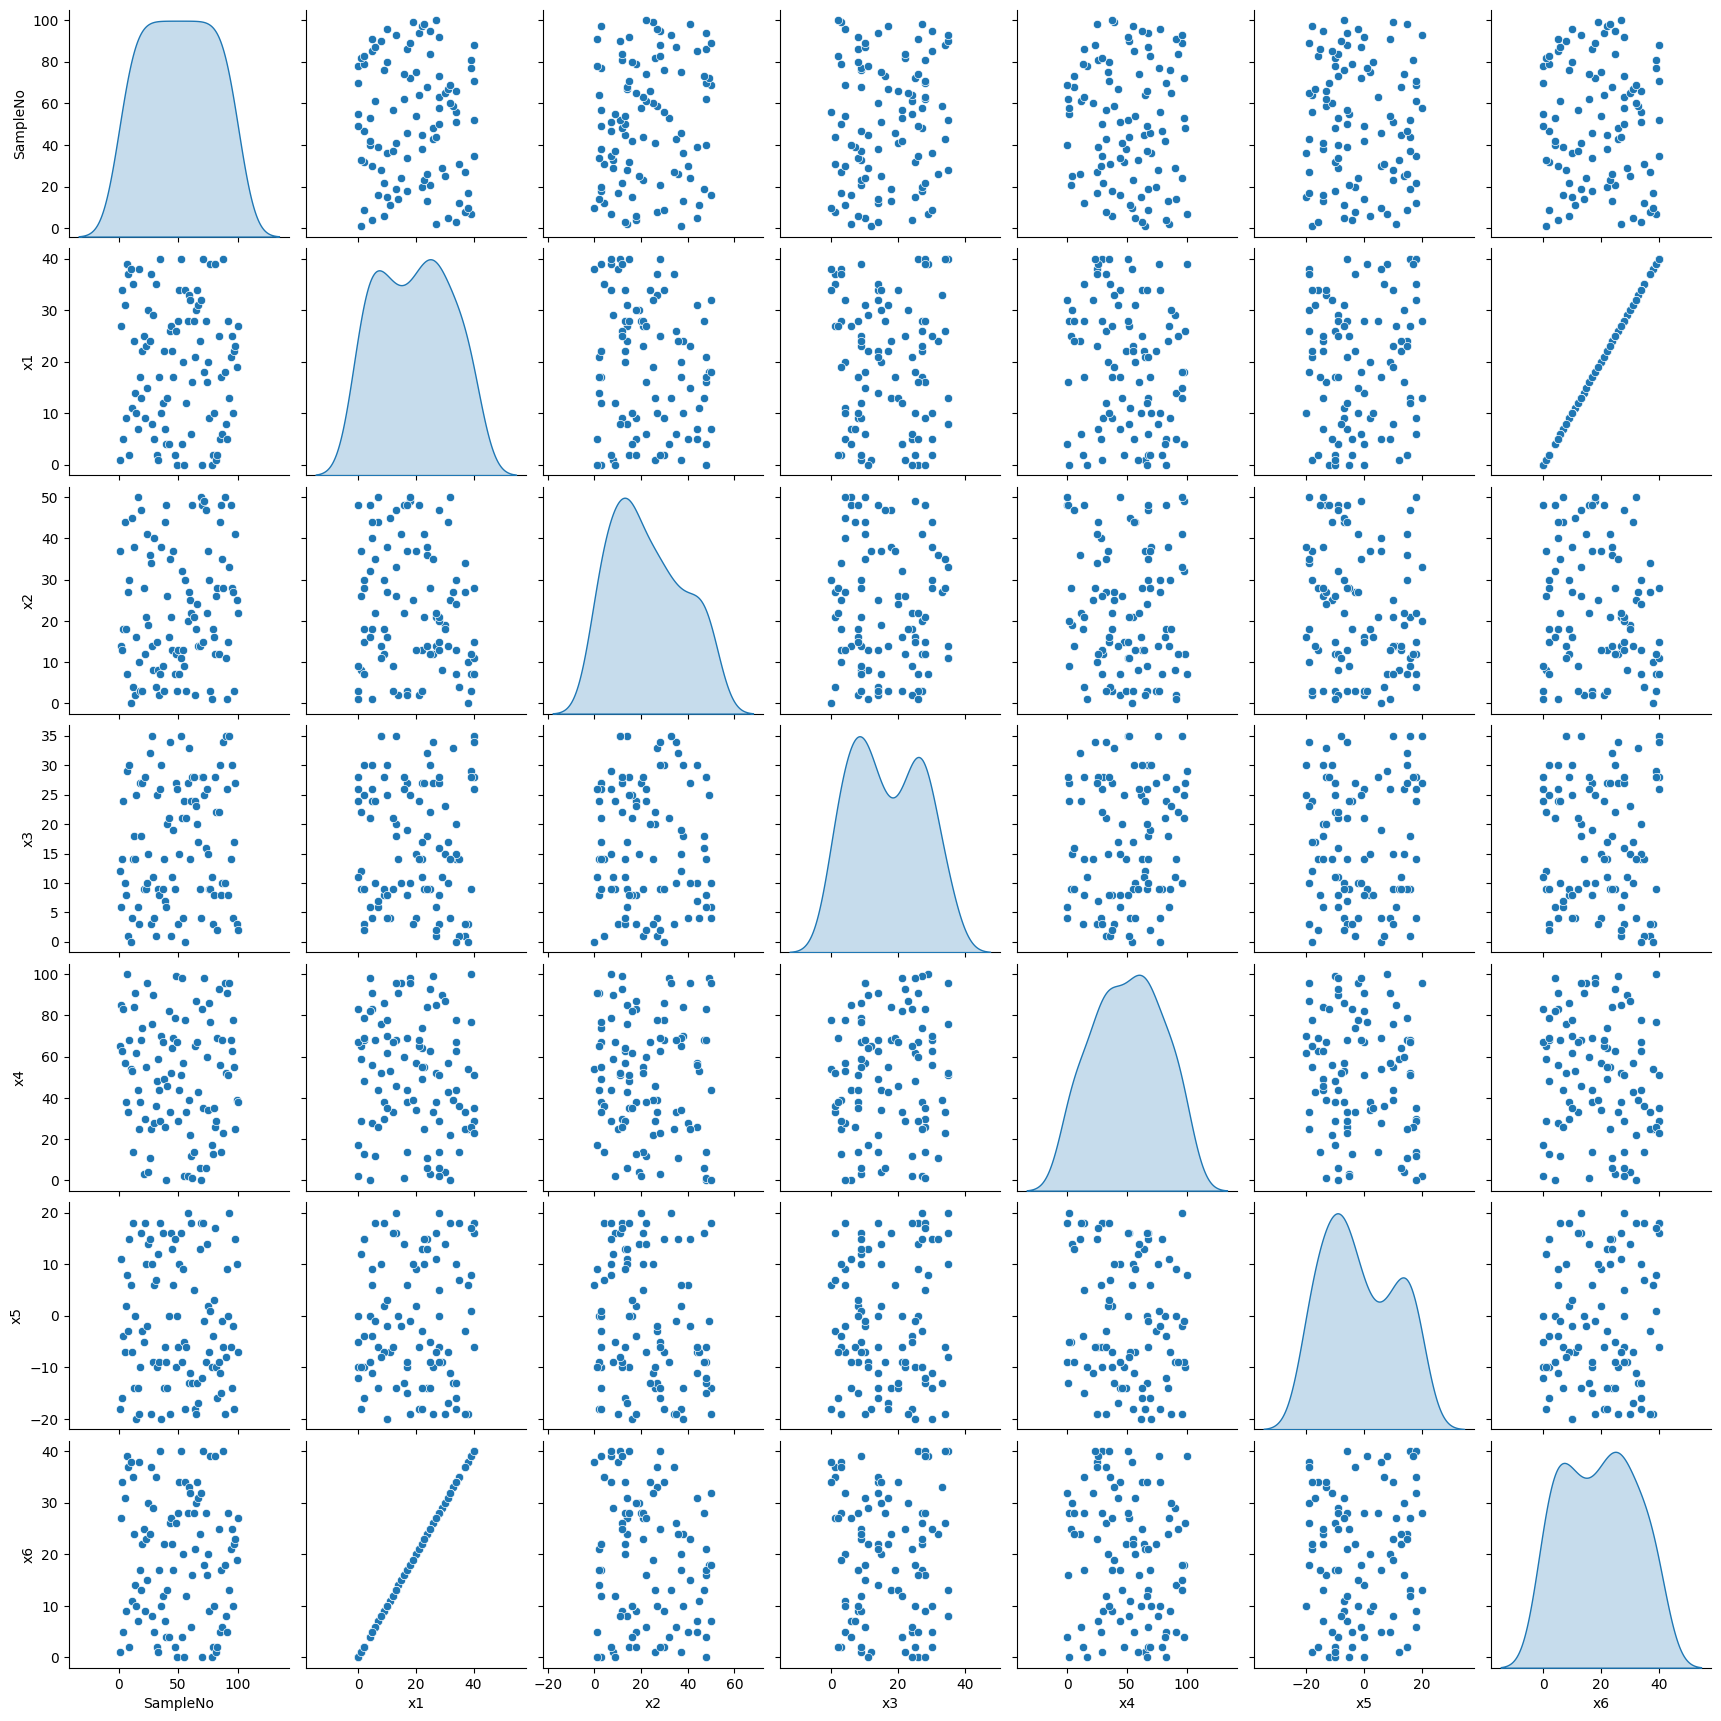

In [452]:
sns.pairplot(dataset[predictors], diag_kind='kde')

From looking at those results, it is clear that x1 and x6 values are exactly the same. So, I have decided to drop x6
predictor since we do not need the same values twice. Also, I have previously included SampleNo as a predictor (even it is
not really logical) just to see if it makes the algorithms perform better, which it obviously did not. So, I am also
dropping the SampleNo from the dataset and the predictors list.

In [453]:
dataset = dataset.drop('x6', axis=1)
predictors.remove('x6')

dataset = dataset.drop('SampleNo', axis=1)
predictors.remove('SampleNo')

features, labels = dataset[predictors], dataset['Y']

predictor_combinations = get_combinations(inputs=predictors)
all_results_table = ModelResultsTable()

table_heuristics = dataset.describe().transpose()[['min', 'max', 'mean', 'std']]
display(table_heuristics)

,min,max,mean,std
x1,0.0,40.0,19.3,12.3
x2,0.0,50.0,22.5,15.0
x3,0.0,35.0,16.7,10.4
x4,0.0,100.0,50.6,28.2
x5,-20.0,20.0,-1.4,12.3
Y,-42.0,12402.0,1746.8,2696.1


Then, I wanted to see how each of the remaining predictors relate to Y separately.

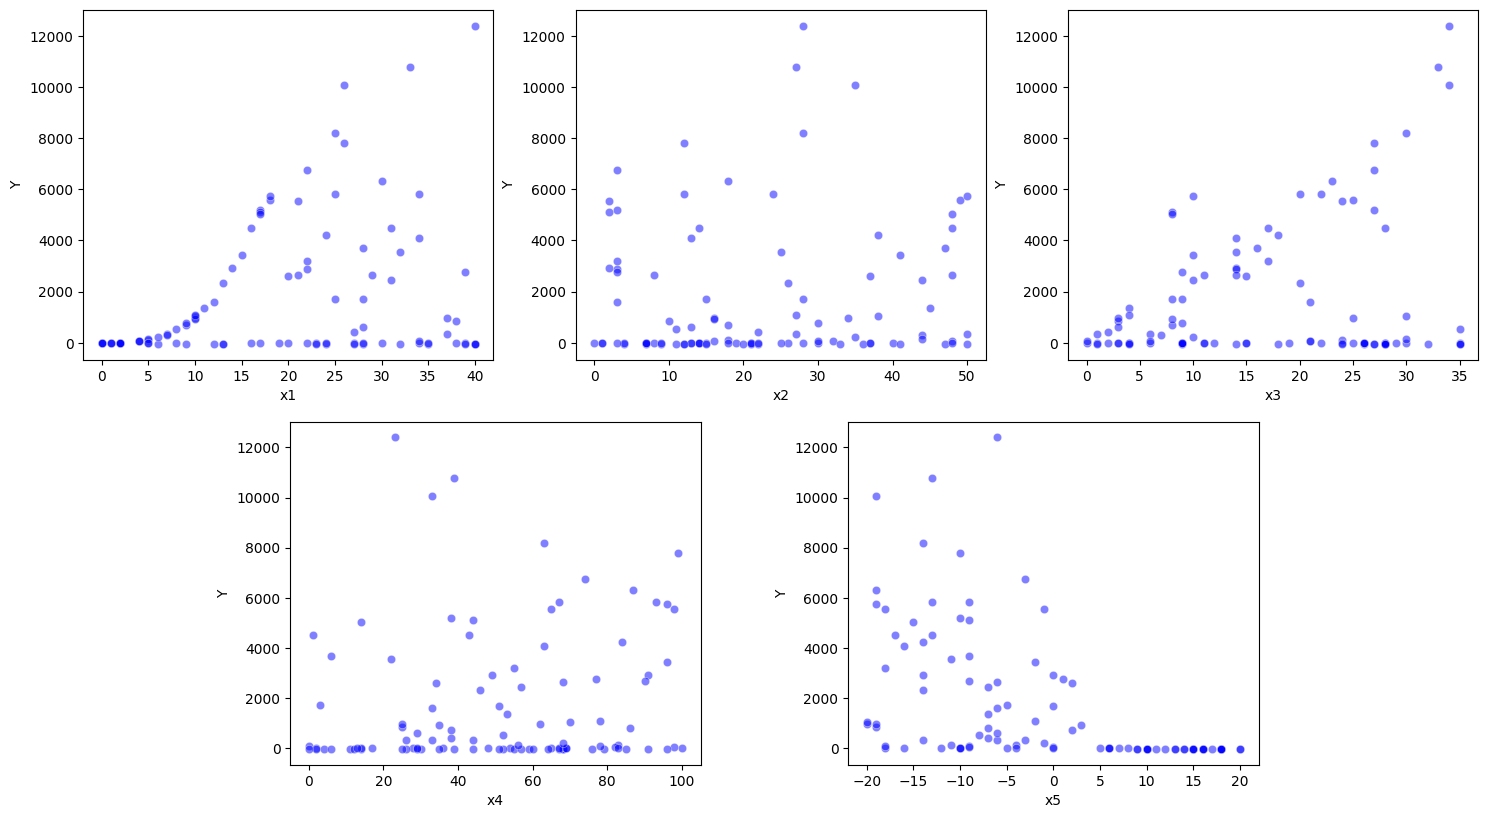

In [454]:
subplot_for_five(dataset)

From here, I can see that when x1 has low values, their corresponding Y values are also tend to be lower. Similarly,
when x5 has a value greater than 5, its corresponding Y value is lower. Because of this, I assumed that some kind of
threshold should separate those plots.

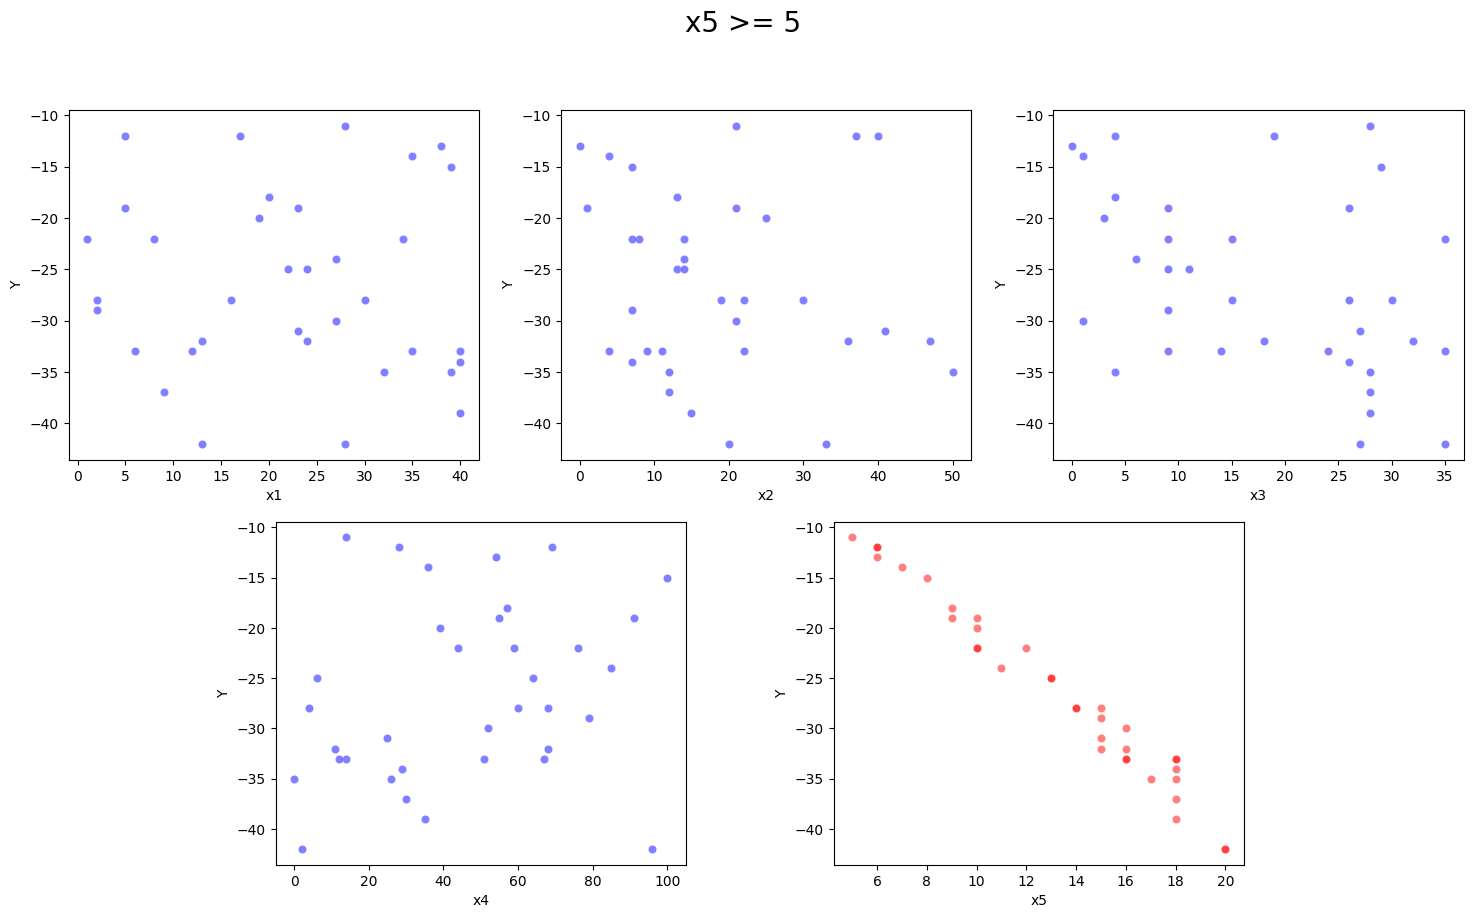

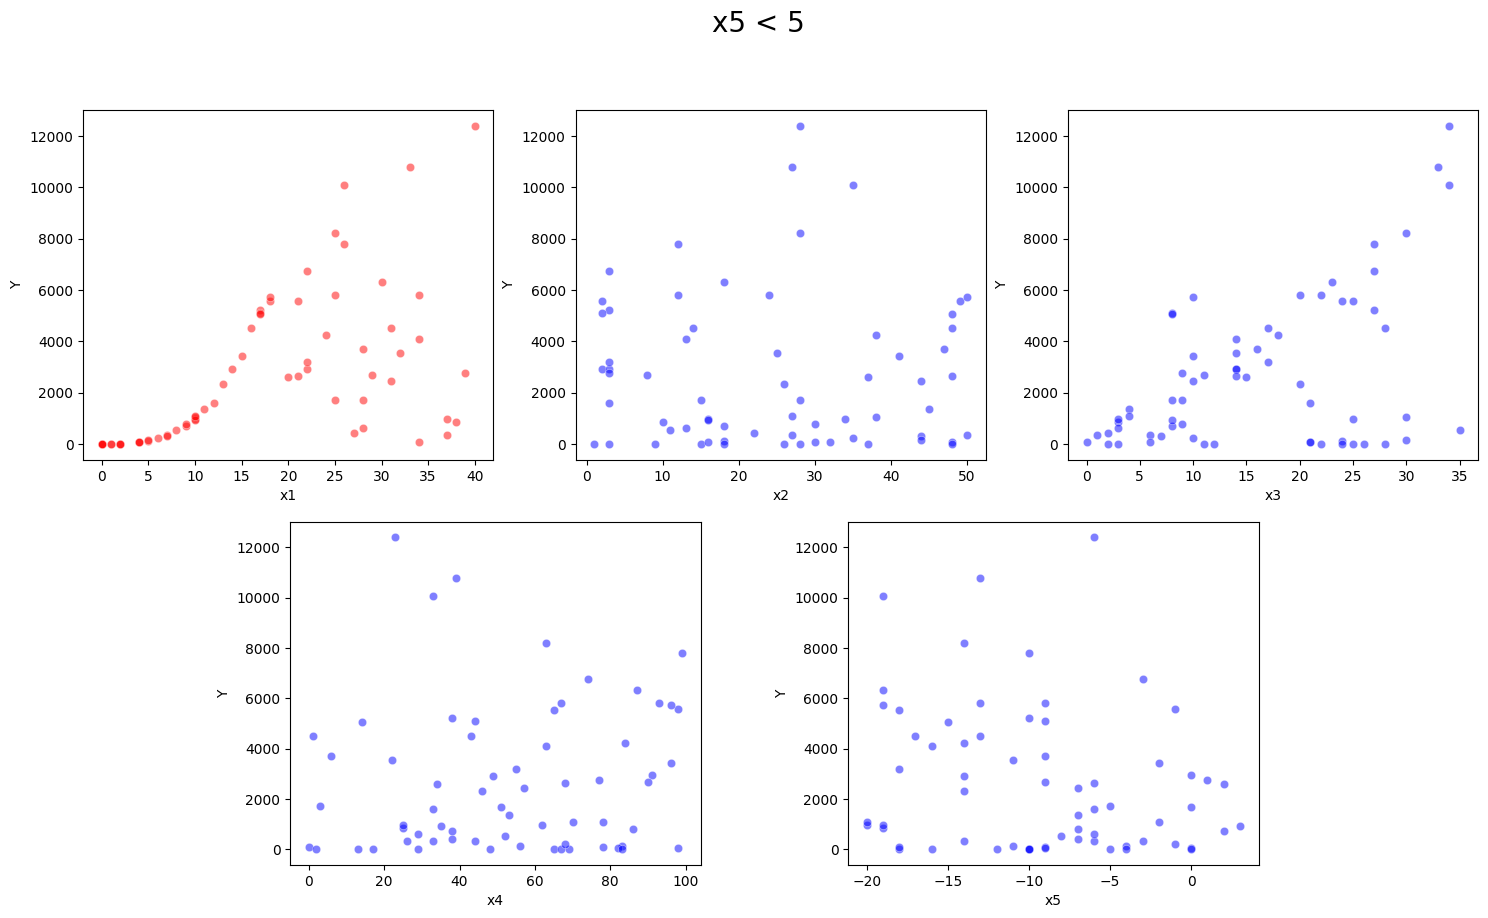

In [455]:
x5_lt, x5_gt = split_by_threshold(dataset, 'x5', threshold=5)
subplot_for_five(data=x5_gt, title='x5 >= 5', highlight=4)
subplot_for_five(data=x5_lt, title='x5 < 5', highlight=0)

Those plots gave me a clear indication that when x5 >= 5, we can apply a linear (or 2nd degree polynomial) regression
line to x5, and it would fit almost perfectly.

What is more interesting is that when x5 does not meet this condition, x1 values that are less than 20 form a 3rd degree
polynomial pattern. So, now I split the remaining data points to also meet this condition.

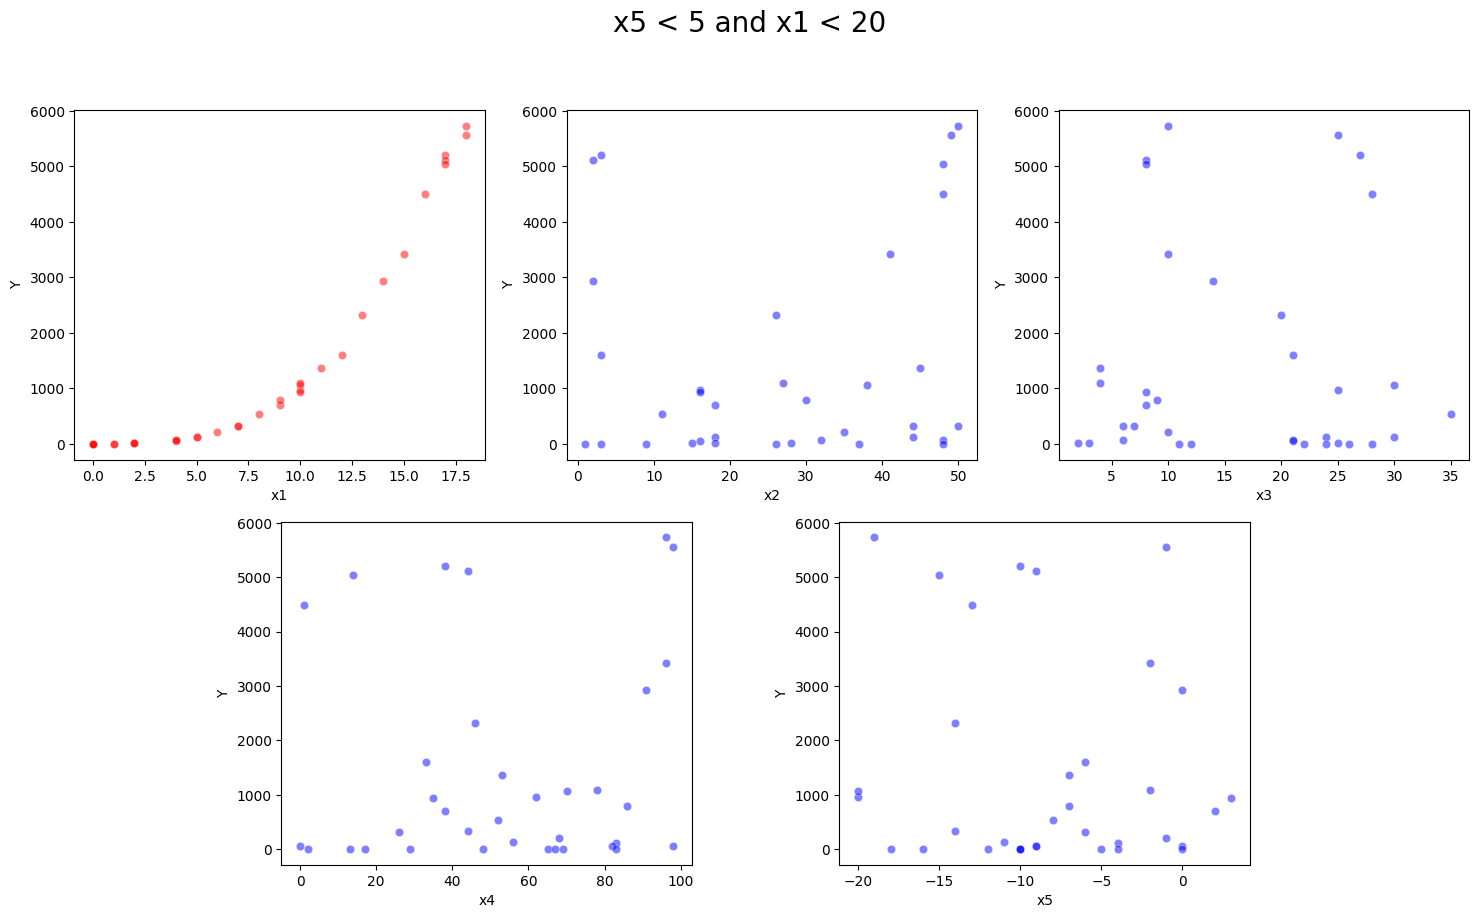

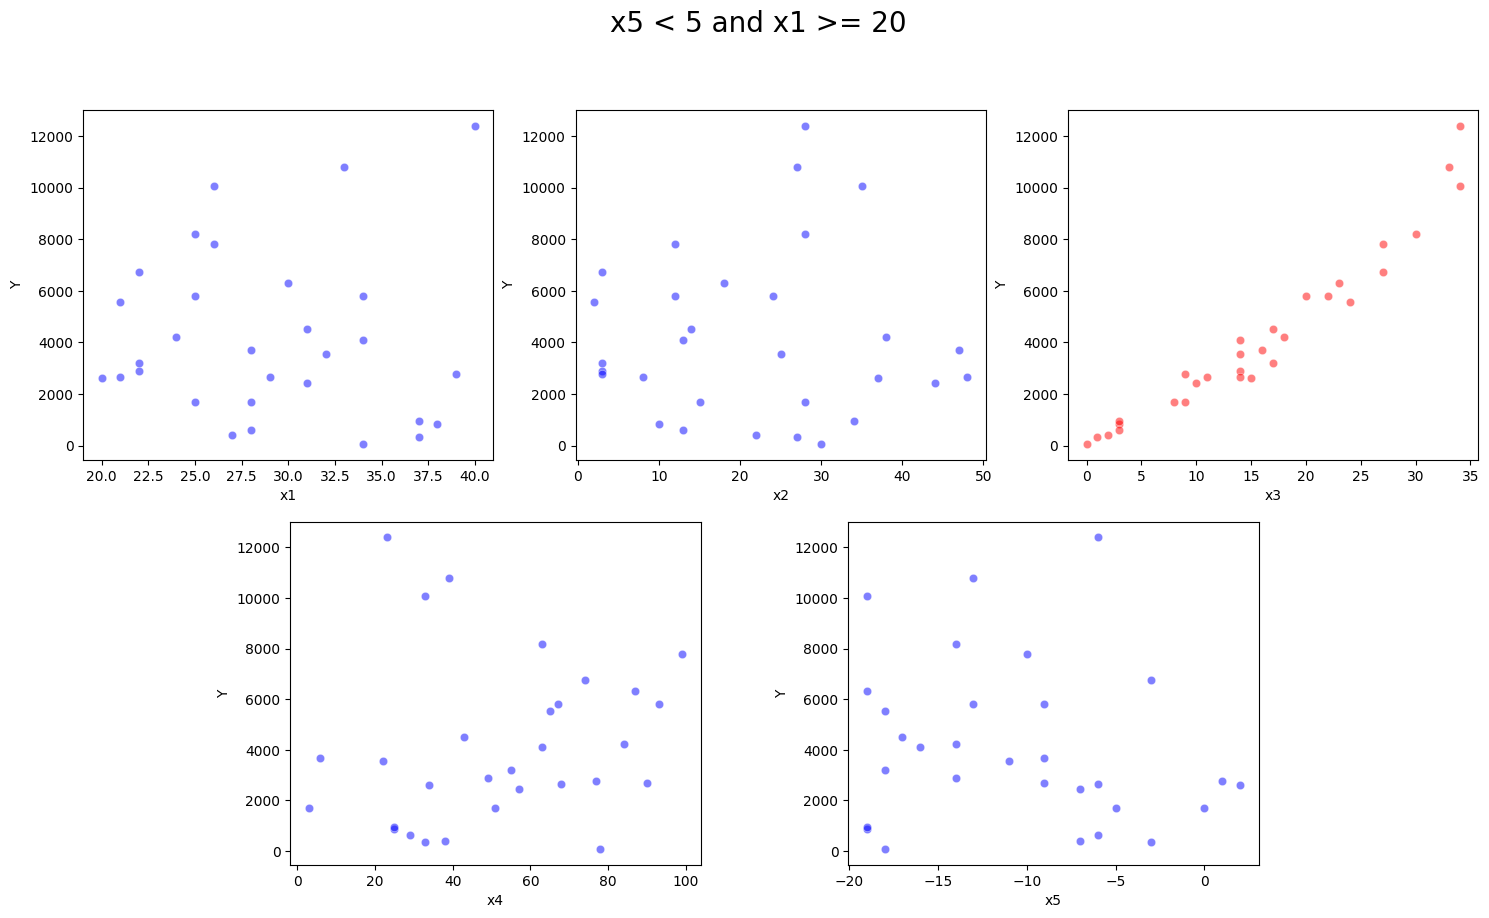

In [456]:
x1_lt, x1_gt = split_by_threshold(x5_lt, 'x1', threshold=20)
subplot_for_five(data=x1_lt, title='x5 < 5 and x1 < 20', highlight=0)
subplot_for_five(data=x1_gt, title='x5 < 5 and x1 >= 20', highlight=2)

As final condition sufficiently fits the points x1 < 20 and x1 >= 20, all outcomes look like the following:

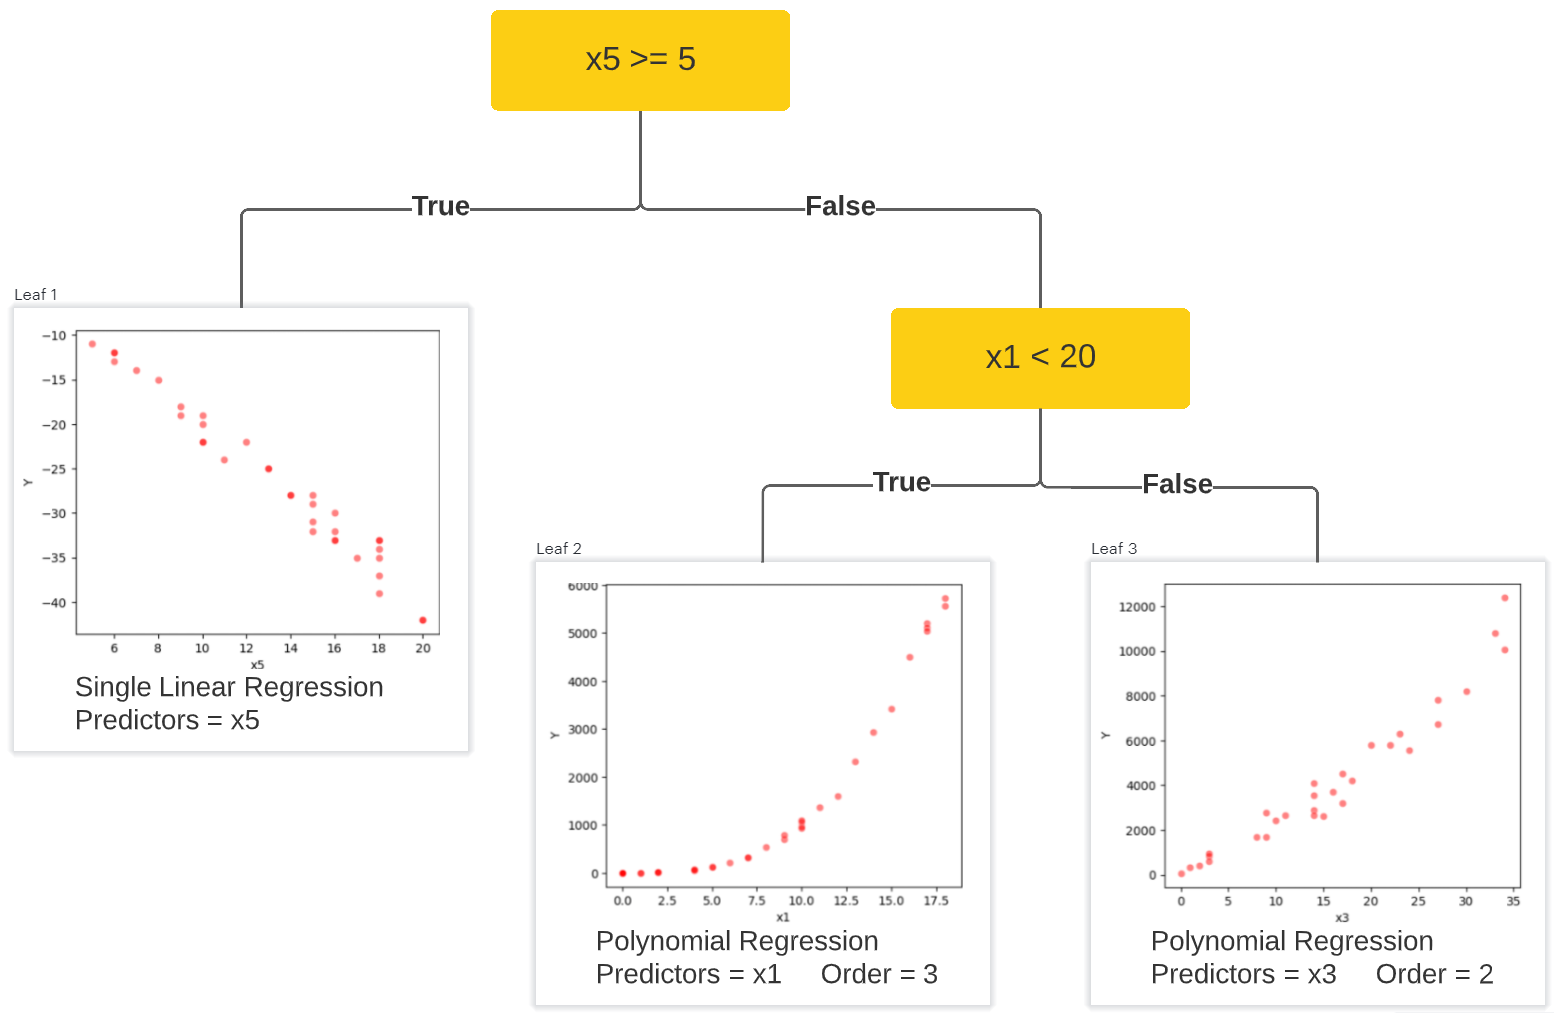

In [457]:
Image(filename='simple_decision_tree.png')

What is written under the plots are what I have considered as "suitable enough" model-parameter selections.
To make the actual best model-predictor-argument selection, I wanted to cross-validate every possible combination.

In [458]:
model_tree = ModelTree(source_set=dataset)
model_tree.fit_conditions(['x5>5', 'x1<20', 'x1>20'])

### Models for the first condition: x5 >= 5,

- All the models are well-fit with very low mean absolute error values for the first condition.
- To keep the complexity low, I stick to my initial choice of Linear Regression with x5 as its input predictor.

In [459]:
first_model_table = model_tree.conditional_fits_table[0].error_table(model='all', top=3, return_table=True)
first_model = first_model_table.iloc[7]

,mae,model,predictors,arg
0,1.2,multiple_linear_regression,"[x3, x5]",
1,1.2,multiple_linear_regression,"[x1, x3, x5]",
2,1.2,multiple_linear_regression,"[x2, x3, x5]",
3,1.2,polynomial_regression,"[x2, x3, x5]",order=2
4,1.3,polynomial_regression,[x5],order=4
5,1.3,polynomial_regression,"[x3, x5]",order=2
6,1.4,decision_tree_regression,[x5],max_depth=4
7,1.4,single_linear_regression,[x5],
8,1.4,decision_tree_regression,[x5],max_depth=5
9,1.4,decision_tree_regression,"[x2, x5]",max_depth=5


### Models for the second condition: x5 < 5 and x1 < 20,

- For the second condition, Polynomial and K-Nearest Regression models are outperforming the others.
- Between these two choices, I have chosen Polynomial Regression models by considering the shape of the plot.
- To keep complexity low again, I choose 3<sup>rd</sup> degree argument over 4<sup>th</sup> degree argument, which was
also my initial choice.

In [460]:
second_model_table = model_tree.conditional_fits_table[1].error_table(model='all', top=3, return_table=True)
second_model = second_model_table.iloc[1]

,mae,model,predictors,arg
0,69.3,polynomial_regression,[x1],order=4
1,76.8,polynomial_regression,[x1],order=3
2,79.8,k_nearest_regression,[x1],k=4
3,80.9,polynomial_regression,"[x1, x3]",order=4
4,96.7,k_nearest_regression,[x1],k=3
5,98.9,k_nearest_regression,[x1],k=2
6,140.7,decision_tree_regression,[x1],max_depth=5
7,159.0,decision_tree_regression,"[x1, x4]",max_depth=4
8,159.1,decision_tree_regression,[x1],max_depth=4
9,787.0,multiple_linear_regression,"[x1, x4]",


### Models for the second condition: x5 < 5 and x1 >= 20,

- For the last condition, Polynomial Regression models outperform any other models that I have tested.
- It looks like my initial choice of parameters couldn't even make up to the top 3 performers for Polynomial Regression
models. It makes sense since the data points on the plot are dense and sparse time to time, so Y should be dependent on
some other predictor or predictors in addition to x3.
- Even though predictors [x1, x3, x4] give the best result, I have decided to only select [x1, x3] to reduce
dimensionality.

In [461]:
third_model_table = model_tree.conditional_fits_table[2].error_table(model='all', top=3, return_table=True)
third_model = third_model_table.iloc[1]

,mae,model,predictors,arg
0,136.9,polynomial_regression,"[x1, x3, x4]",order=2
1,150.1,polynomial_regression,"[x1, x3]",order=2
2,155.2,polynomial_regression,"[x1, x3]",order=3
3,368.8,multiple_linear_regression,"[x1, x3]",
4,372.0,multiple_linear_regression,"[x1, x3, x4]",
5,377.5,multiple_linear_regression,"[x1, x2, x3]",
6,528.5,k_nearest_regression,"[x1, x3]",k=2
7,573.1,k_nearest_regression,"[x1, x3]",k=3
8,601.5,k_nearest_regression,[x3],k=2
9,641.6,decision_tree_regression,"[x1, x3, x4]",max_depth=5


In [462]:
selected_models = [first_model, second_model, third_model]
model_tree.select_leaf_models(model_results=selected_models)

Total CV Score (MAE) = 228.26


,Model,Predictors,Args,Error
x5>=5,single_linear_regression,[x5],,1.4
x5<5 && x1<20,polynomial_regression,[x1],order=3,76.8
x5<5 && x1>=20,polynomial_regression,"[x1, x3]",order=2,150.1


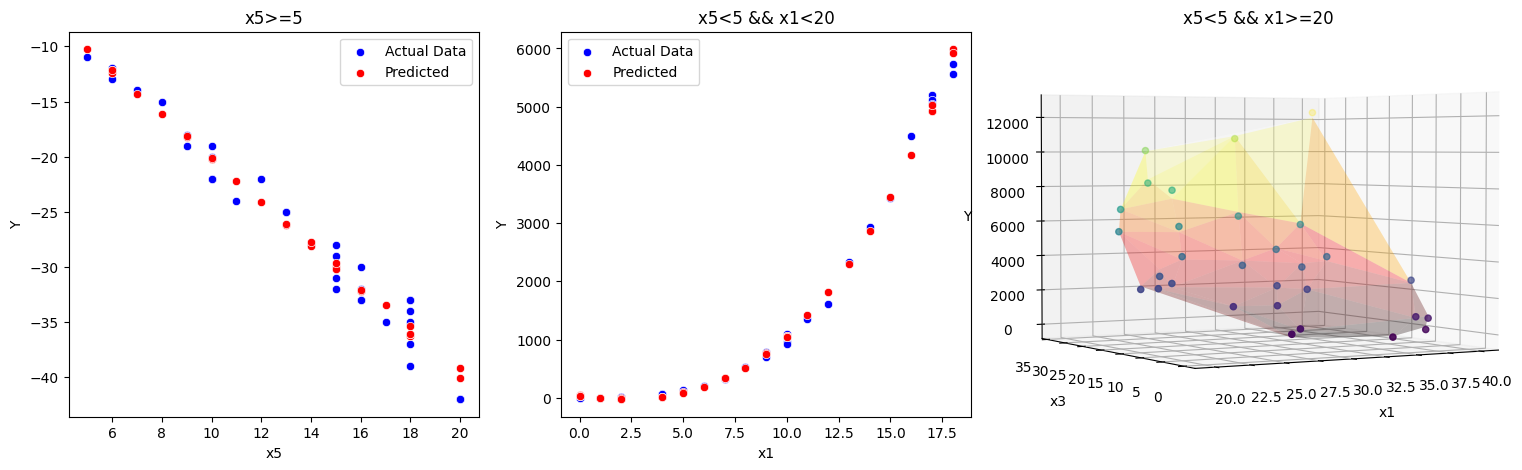

In [463]:
titles = ['x5>=5', 'x5<5 && x1<20', 'x5<5 && x1>=20']
model_tree.plot_models(plot_titles=titles, angle_3d=240, cmap='hot')

m_args = []
m_predictors = []
m_error = []
for model_tree_result in model_tree.leaf_models:
    m_args.append(model_tree_result.arg)
    m_predictors.append(model_tree_result.predictors)
    m_error.append(model_tree_result.error)

model_tree_result = ModelResult({'model': 'model_tree_regression(?)',
                                 'arg': m_args,
                                 'predictors': m_predictors,
                                 'predicted': None,
                                 'error': sum(m_error),
                                 'estimator': model_tree})

all_results_table.add_model([model_tree_result])

# IV. Scikit-learn Regression Models

## IV.I. Single Linear Regression

,,,,,
predictors,x5,x1,x3,x4,x2
mae,1617.4,1926.8,2058.3,2086.5,2119.9


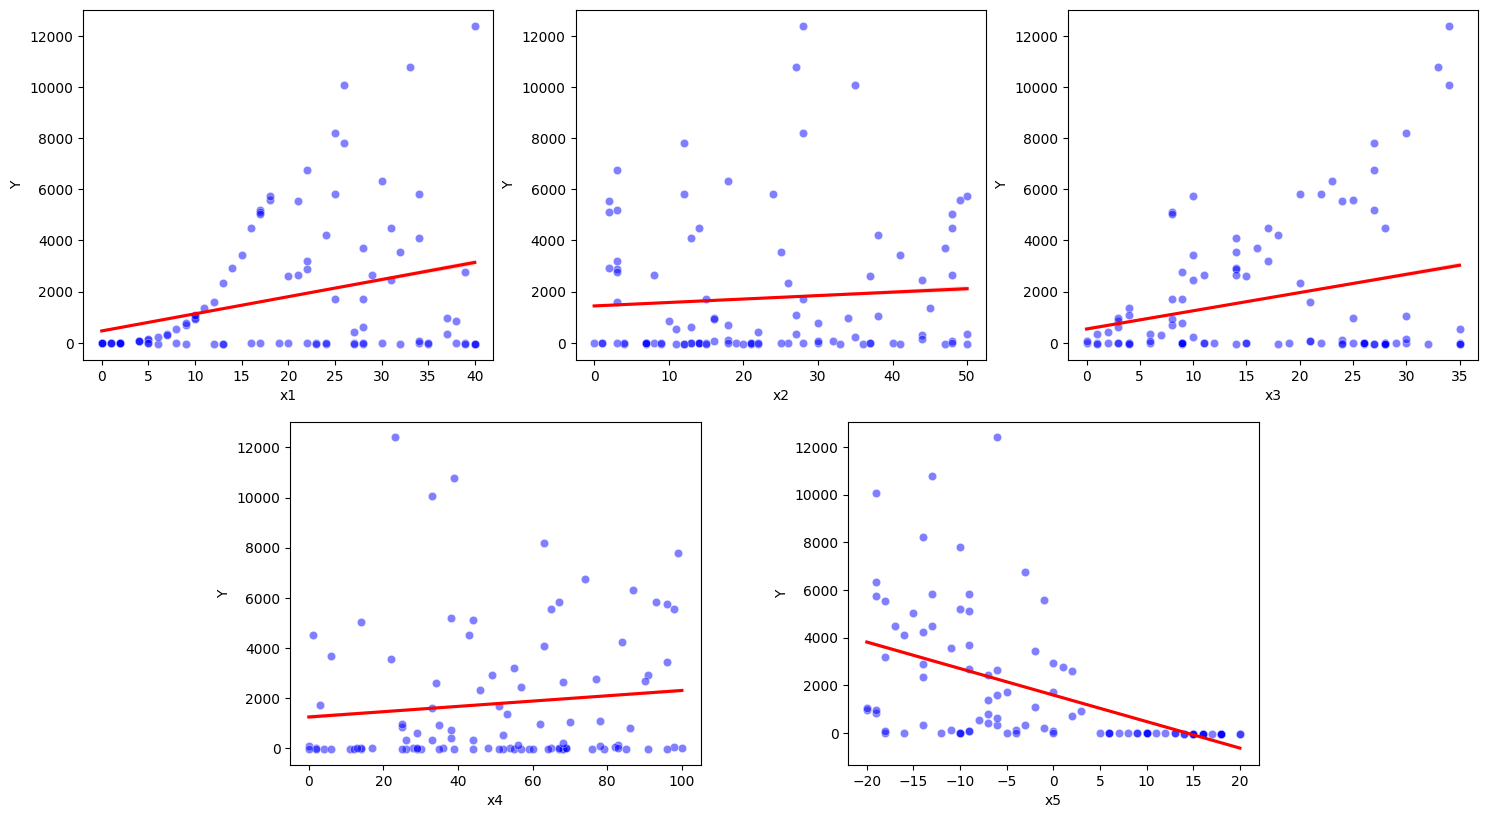

In [464]:
lin_reg_args = predictors
lin_reg_results = [single_linear_regression(x=features, y=labels, inputs=p)
                   for p in lin_reg_args]

subplot_for_five(dataset, reg_plot=lin_reg_results)

all_results_table.add_model(lin_reg_results)
all_results_table.error_table(model='single_linear_regression', transpose=True)

## IV.II. Multiple Linear Regression

In [465]:
multi_lin_reg_args = get_combinations(inputs=predictors)
multi_lin_reg_results = [multiple_linear_regression(x=features, y=labels, inputs=ps)
                         for ps in multi_lin_reg_args]

all_results_table.add_model(multi_lin_reg_results)
all_results_table.error_table(model='multiple_linear_regression', transpose=True)

,,,,,,,,,,,...,,,,,,,,,,
predictors,"[x1, x2, x3, x4, x5]","[x1, x2, x3, x5]","[x1, x3, x4, x5]","[x1, x3, x5]","[x1, x4, x5]","[x1, x2, x4, x5]","[x1, x5]","[x1, x2, x5]","[x3, x5]","[x3, x4, x5]",...,"[x1, x2, x3, x4]","[x1, x2, x4]","[x1, x2, x3]","[x1, x3, x4]","[x1, x3]","[x1, x2]","[x3, x4]","[x2, x3, x4]","[x2, x3]","[x2, x4]"
mae,1511.9,1517.5,1523.6,1524.5,1567.5,1576.5,1582.8,1589.5,1619.0,1619.3,...,1911.6,1916.2,1918.7,1927.8,1930.4,1931.3,2051.0,2051.1,2056.9,2095.5


## IV.III. Polynomial Regression

In [466]:
poly_reg_args = [2, 3, 4]
poly_reg_results = [polynomial_regression(features, labels, arg=order, inputs=p)
                    for order in poly_reg_args
                    for p in predictor_combinations]

all_results_table.add_model(poly_reg_results)
all_results_table.error_table(model='polynomial_regression', transpose=True)

,order=3,order=4,order=3,order=2,order=2,order=3,order=2,order=2,order=3,order=4,...,order=4,order=4,order=4,order=4,order=4,order=4,order=4,order=4,order=4,order=4
predictors,"[x1, x3, x5]","[x1, x3, x5]","[x1, x2, x3, x5]","[x1, x3, x5]","[x1, x2, x3, x5]","[x1, x3, x4, x5]","[x1, x2, x3, x4, x5]","[x1, x3, x4, x5]","[x1, x5]","[x1, x5]",...,"[x2, x4, x5]","[x2, x3, x5]","[x1, x2, x4]","[x1, x3, x4, x5]","[x1, x2, x3, x5]","[x2, x3, x4]","[x1, x2, x3, x4]","[x2, x3, x4, x5]","[x1, x2, x4, x5]","[x1, x2, x3, x4, x5]"
mae,822.4,898.7,1005.2,1045.1,1054.6,1070.2,1090.2,1107.7,1291.0,1307.1,...,2434.7,2585.9,2747.6,3079.7,3156.4,3271.2,4555.3,6535.9,7716.9,12615.0


## IV.IV. K-Nearest-Neighbors Regression

In [467]:
knn_reg_args = range(1, 6)
knn_reg_results = [k_nearest_regression(features, labels, arg=k, inputs=p)
                   for k in knn_reg_args
                   for p in predictor_combinations]

all_results_table.add_model(knn_reg_results)
all_results_table.error_table(model='k_nearest_regression', transpose=True)

,k=1,k=2,k=3,k=4,k=5,k=2,k=3,k=3,k=4,k=1,...,k=5,k=2,k=2,k=1,k=1,k=4,k=1,k=5,k=3,k=1
predictors,"[x1, x3, x5]","[x1, x3, x5]","[x1, x3, x5]","[x1, x3, x5]","[x1, x3, x5]","[x1, x2, x3, x5]","[x1, x2, x3, x5]","[x1, x5]","[x1, x5]","[x1, x2, x3, x5]",...,"[x3, x4]","[x2, x4]","[x2, x3]","[x2, x3]","[x2, x3, x4]","[x2, x4]","[x3, x4]","[x2, x4]","[x2, x4]","[x2, x4]"
mae,555.1,601.4,648.2,692.4,706.4,847.3,853.1,873.6,895.8,902.9,...,2148.9,2175.3,2179.5,2209.6,2224.1,2267.3,2269.1,2294.3,2295.1,2466.5


## IV.V. Decision Tree Regression

In [468]:
dec_tree_args = range(1, 6)
dec_tree_results = [decision_tree_regression(features, labels, arg=depth, inputs=p)
                    for depth in dec_tree_args
                    for p in predictor_combinations]

all_results_table.add_model(dec_tree_results)
all_results_table.error_table(model='decision_tree_regression', transpose=True)

,max_depth=5,max_depth=5,max_depth=4,max_depth=5,max_depth=5,max_depth=4,max_depth=4,max_depth=4,max_depth=3,max_depth=3,...,max_depth=3,max_depth=2,max_depth=3,max_depth=1,max_depth=4,max_depth=1,max_depth=1,max_depth=1,max_depth=2,max_depth=5
predictors,"[x1, x3, x5]","[x1, x2, x3, x5]","[x1, x3, x5]","[x1, x3, x4, x5]","[x1, x2, x3, x4, x5]","[x1, x2, x3, x5]","[x1, x2, x3, x4, x5]","[x1, x3, x4, x5]","[x1, x3, x5]","[x1, x2, x3, x5]",...,"[x2, x3]","[x2, x3]","[x2, x4]","[x2, x4]","[x2, x4]","[x2, x3]","[x3, x4]","[x2, x3, x4]","[x2, x4]","[x2, x4]"
mae,460.4,509.5,546.1,546.8,579.7,586.6,641.6,694.7,846.0,846.0,...,1980.6,1981.5,2007.3,2062.4,2117.7,2126.5,2126.5,2126.5,2161.0,2483.8


## IV.VI. Random Forest Regression

In [469]:
rf_args = range(1, 6)
rand_forest_results = [random_forest_regression(features, labels, arg=depth, inputs=p)
                       for depth in rf_args
                       for p in predictor_combinations]

all_results_table.add_model(rand_forest_results)
all_results_table.error_table(model='random_forest_regression', transpose=True)

,max_depth=5,max_depth=5,max_depth=4,max_depth=5,max_depth=4,max_depth=5,max_depth=4,max_depth=4,max_depth=5,max_depth=4,...,max_depth=1,max_depth=1,max_depth=3,max_depth=2,max_depth=4,max_depth=1,max_depth=1,max_depth=1,max_depth=1,max_depth=5
predictors,"[x1, x3, x5]","[x1, x2, x3, x5]","[x1, x3, x5]","[x1, x3, x4, x5]","[x1, x2, x3, x5]","[x1, x2, x3, x4, x5]","[x1, x3, x4, x5]","[x1, x2, x3, x4, x5]","[x1, x5]","[x1, x5]",...,"[x1, x2, x3, x4]","[x1, x3, x4]","[x2, x4]","[x2, x4]","[x2, x4]","[x2, x4]","[x3, x4]","[x2, x3, x4]","[x2, x3]","[x2, x4]"
mae,589.8,633.1,665.4,701.7,705.4,732.2,771.7,808.0,839.3,855.6,...,1969.7,1970.3,2039.3,2055.8,2076.4,2080.3,2087.2,2089.6,2094.5,2123.3


# V. Conclusion

In [470]:
all_results_table.error_table(model='best')

,args,predictors,mae
model_tree_regression(?),"[, order=3, order=2]","[[x5], [x1], [x1, x3]]",228.3
decision_tree_regression,max_depth=5,"[x1, x3, x5]",460.4
k_nearest_regression,k=1,"[x1, x3, x5]",555.1
random_forest_regression,max_depth=5,"[x1, x3, x5]",589.8
polynomial_regression,order=3,"[x1, x3, x5]",822.4
multiple_linear_regression,,"[x1, x2, x3, x4, x5]",1511.9
single_linear_regression,,x5,1617.4


In [471]:
best_model = all_results_table.model_results_with_best_params[0].estimator

final_predictions = best_model.predict(x=predict_set)
with pd.option_context('display.max_rows', None):
    display(final_predictions)

C:\Users\egeal\Documents\GitHub\CE475-Project\venv\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


,Predictions
100,-10.3
101,-26.1
102,192.0
103,1402.7
104,-39.9
105,-3.4
106,-18.5
107,139.4
108,9854.7
109,-36.0


In [472]:
%reload_ext watermark
%watermark -v -m -p sklearn,pandas,numpy,matplotlib,seaborn
%watermark -u -n -t -z

Python implementation: CPython
Python version       : 3.10.4
IPython version      : 8.3.0

sklearn   : 1.1.1
pandas    : 1.4.2
numpy     : 1.22.4
matplotlib: 3.5.2
seaborn   : 0.11.2

Compiler    : MSC v.1929 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 167 Stepping 1, GenuineIntel
CPU cores   : 12
Architecture: 64bit

Last updated: Thu Jun 09 2022 02:12:36Turkey Standard Time

